In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astroML.stats
from astropy.table import Table
from tqdm import tqdm
from astropy.visualization.hist import hist as fancyhist

import pandas
pandas.set_option('display.max_columns', None)

%matplotlib inline
#%config InlineBackend.figure_format='retina'
plt.style.use(['labstyle.mplstyle']) 

# Functions

In [2]:
def Plot(x_data, y_data, x_label='', y_label='', data_mask=None, 
         xlog=True, ylog=True, x_min=None, x_max=None, y_min=None, y_max=None, hist2d_nbins=200, 
         x_min_bins=None, x_max_bins=None, xbins=40):
    
    if x_min==None: x_min = np.min(x_data)
    if x_max==None: x_max = np.max(x_data)
    if y_min==None: y_min = np.min(y_data)
    if y_max==None: y_max = np.max(y_data)
    
    
    # Define the figure
    fig, ax = plt.subplots(1, figsize=(10,9))
    ax.set_box_aspect(1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    if xlog==True: ax.set_xscale('log')
    if ylog==True: ax.set_yscale('log')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    
    # Plot the 2d-histogram
    binx = np.logspace(start=np.log10(x_min), stop=np.log10(x_max), num=hist2d_nbins)
    biny = np.logspace(start=np.log10(y_min), stop=np.log10(y_max), num=hist2d_nbins)
    hist = ax.hist2d(x_data, y_data, bins=(binx, biny), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.coolwarm, alpha=0.5)
    cax = fig.add_axes([0.91, 0.11, 0.02, 0.77])
    fig.colorbar(hist[3], cax=cax, label='$N_{points}/bin$')
    
    
    # Plot the statistics
    if data_mask is not None:
        x_data = x_data[data_mask]
        y_data = y_data[data_mask]
    
    if x_min_bins==None: x_min_bins = x_min
    if x_max_bins==None: x_max_bins = x_max
    
    bin_edges = np.logspace(start=np.log10(x_min_bins), stop=np.log10(x_max_bins), num=xbins+1)
    statistics = np.zeros(shape=(int(xbins), 5))
    
    for i in range(int(xbins)):
        mask_bin = ((x_data>=bin_edges[i]) & (x_data<bin_edges[i+1]))
        x_temp = np.array(x_data[mask_bin])
        y_temp = np.array(y_data[mask_bin])
        N_temp = int(len(x_temp))
        statistics[i] = np.array([N_temp, 
                                  np.median(x_temp), 
                                  np.median(y_temp), 
                                  np.quantile(y_temp, 0.25),
                                  np.quantile(y_temp, 0.75)])

    ax.plot(statistics[:,1], statistics[:,2], color='black')
    ax.plot(statistics[:,1], statistics[:,3], color='black', alpha=0.5)
    ax.plot(statistics[:,1], statistics[:,4], color='black', alpha=0.5)
    ax.fill_between(statistics[:,1], statistics[:,3], statistics[:,4], color='gray', alpha=0.15)
     
    return fig, ax, statistics, hist

In [3]:
# Function to extract relevant infromations about some data by binning them and
# searching for some variable inside the bins
#
# x_data: the data to be binned
# qty_mask: a mask on x_data that tells whether each element has some (user speecifed) property or not
# bin_type: the type of spacing along x_data to be used to make the bins
# xbins: the number of bins
# x_min, x_max: user specified bounds to be used to bin the data
def Bin_analysis(x_data, qty_mask,
                 bin_type='log', xbins=20,
                 x_min=None, x_max=None):
    # If not specified, use data limits as bounds for the binning
    if x_min == None: x_min = np.min(x_data)
    if x_max == None: x_max = np.max(x_data)

    # Use the specified bins spacing
    if bin_type.lower() == 'log':
        bin_edges = np.logspace(start=np.log10(x_min), stop=np.log10(x_max), num=xbins+1)
    elif bin_type.lower() == 'lin':
        bin_edges = np.linspace(start=x_min, stop=x_max, num=xbins+1)
    elif bin_type.lower() == 'geom':
        bin_edges = np.geomspace(start=x_min, stop=x_max, num=xbins+1)
    elif bin_type.lower() == 'scott': 
        bin_edges = (fancyhist(x_data, bins="scott", histtype="step", density=True))[1]
    elif bin_type.lower() == 'freedman': 
        bin_edges = fancyhist(x_data, bins="freedman", histtype="step", density=True)[1]

    # An array of (empty) dictionaries
    bins_info = np.array([dict() for i in range(len(bin_edges)-1)])

    for i in range(len(bin_edges)-1):
        # Make a mask of the current bin
        bin_mask = (x_data >= bin_edges[i]) & (x_data < bin_edges[i+1])

        # Make a mask of the inspected quantity inside the bin
        qty_bin_mask = qty_mask & bin_mask

        # Get the elements inside the current bin
        x_bin = x_data[bin_mask]

        # Fill the bin's dictionary with useful informations
        bins_info[i]['n_tot'] = np.sum(bin_mask)
        bins_info[i]['n_qty'] = np.sum(qty_bin_mask)
        bins_info[i]['mean'] = np.mean(x_bin)
        # If the bin is empty, set its statistics to zero
        if bins_info[i]['n_tot'] == 0:
            bins_info[i]['qty_frac'] = 0
            bins_info[i]['mean_err'] = 0
            bins_info[i]['quantiles'] = np.array([0, 0, 0, 0, 0])
        else:
            bins_info[i]['qty_frac'] = bins_info[i]['n_qty'] / bins_info[i]['n_tot']
            bins_info[i]['mean_err'] = np.std(x_bin, ddof=1) / np.sqrt(bins_info[i]['n_tot'])
            bins_info[i]['quantiles'] = np.quantile(x_bin, [0.05, 0.16, 0.5, 0.84, 0.95])

    return bins_info

# A function to plot informations contained in a bins_info object from the Bin_analysis() function
#
# bins_info: the object containing the data (see Bin_analysis())
# x_key, y_key: the keys of the dictionaries inside bins_info that contains the data to plot
# x_scale, y_scale: the scales of the axis. Matplotlib values are available
# plt_err: whether to plot error bars on the x axis or not
# err_type: the key of the dictionaries inside bins_info containing the errors
# q: if x_key or y_key='quantiles' q is the index of the quantile to use
# q_err: if err_type='quantiles', q_err is a list of 2 indexes of the quantiles to use 
# x_low, x_up, y_low, y_up: limits of the axes
# bad_bins: a list of indexes of the bins contained in bins_info to be excluded from the plot
# Other parameters are just for styling the plot. They are passed as they are to the plotting functions
# They can have any value accepted by Matplotlib
def Bin_plotter(bins_info, x_key='mean_err', y_key='qty_frac',
                x_scale='log', y_scale='linear',
                plt_err=True, err_type='mean_err', q=2, q_err=[1, 3],
                marker='.', markersize=None,
                linestyle='', linewidth=None, elinewidth=None,
                x_label=None, y_label=None, title=None, figsize=None,
                color=None, ecolor=None,
                markerfacecolor=None, markeredgecolor=None,
                label=None,
                x_low=None, x_up=None, y_low=None, y_up=None,
                bad_bins=[]):
    # Initialise the plot
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xscale(x_scale)
    ax.set_yscale(y_scale)

    # Get the good bins
    good_bins = [i for i in range(len(bins_info)) if i not in bad_bins]

    # Initialise variables for the data to plot
    x_data = np.zeros(len(bins_info))
    y_data = np.zeros(len(bins_info))

    # Get the data to plot
    for i in range(len(bins_info)):
        if x_key == 'quantiles':
            x_data[i] = bins_info[i][x_key][q]
        else:
            x_data[i] = bins_info[i][x_key]

        if y_key == 'quantiles':
            y_data[i] = bins_info[i][y_key][q]
        else:
            y_data[i] = bins_info[i][y_key]

    # Plot errors only if required
    if plt_err:
        if err_type == 'mean_err':
            x_err = np.array([bins_info[i][err_type] for i in range(len(bins_info))])

            ax.errorbar(x_data[good_bins], y_data[good_bins], xerr=x_err[good_bins],
                        marker=marker, markersize=markersize,
                        linestyle=linestyle, linewidth=linewidth, elinewidth=elinewidth,
                        color=color, ecolor=ecolor,
                        markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                        label=label)
        elif err_type == 'quantiles':
            # Get the required quantiles
            x_err = np.array([bins_info[i][err_type][q_err] for i in range(len(bins_info))])

            # Compute the lower and upper error using the quantiles
            x_err[:, 0] = x_data - x_err[:, 0]
            x_err[:, 1] = x_err[:, 1] - x_data

            # for asymmetric errors xerr must have shape (2, N) (see Matplotlib documentation)
            ax.errorbar(x_data[good_bins], y_data[good_bins], xerr=np.swapaxes(x_err[good_bins], 0, 1),
                        marker=marker, markersize=markersize,
                        linestyle=linestyle, linewidth=linewidth, elinewidth=elinewidth,
                        color=color, ecolor=ecolor,
                        markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                        label=label)
    else:
        ax.plot(x_data[good_bins], y_data[good_bins],
                marker=marker, markersize=markersize,
                linestyle=linestyle, linewidth=linewidth,
                color=color,
                markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                label=label)

    # Plotting errros seems to produce some strange behaviors of the artists in the figure
    # relim() recompute the data limits based on current artists
    # By default it includes also invisible artists
    ax.relim(visible_only=False)

    # Get the current limits of the axis
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # If user's limits are not specified, don't change them
    if x_low == None: x_low = x_lim[0]
    if x_up == None: x_up = x_lim[1]
    if y_low == None: y_low = y_lim[0]
    if y_up == None: y_up = y_lim[1]

    # Update the axes limits
    ax.set_xlim(x_low, x_up)
    ax.set_ylim(y_low, y_up)

    if label != None:
        ax.legend()

    return fig, ax

# Lecture 5

## Generate parameters in log-scale

In [4]:
def precision_round(number, digits=2):
    power = "{:e}".format(number).split('e')[1]
    return round(number, -(int(power) - digits))

### Tau

In [5]:
params = np.logspace(start=np.log10(5), stop=np.log10(30000), num=40)

for i in range(len(params)):
    params[i] = precision_round(params[i])
    
print(''.join(str(num)+', ' for num in params))

5.0, 6.25, 7.81, 9.76, 12.2, 15.3, 19.1, 23.8, 29.8, 37.2, 46.5, 58.2, 72.7, 90.9, 114.0, 142.0, 177.0, 222.0, 277.0, 346.0, 433.0, 541.0, 676.0, 845.0, 1060.0, 1320.0, 1650.0, 2060.0, 2580.0, 3220.0, 4030.0, 5040.0, 6290.0, 7870.0, 9830.0, 12300.0, 15400.0, 19200.0, 24000.0, 30000.0, 


### Age

In [6]:
params = np.logspace(start=np.log10(20), stop=3, num=10)
params = np.append(params, np.arange(1500, 13500, step=500))

for i in range(len(params)):
    params[i] = precision_round(params[i])
    
print(''.join(str(num)+', ' for num in params))

20.0, 30.9, 47.7, 73.7, 114.0, 176.0, 271.0, 419.0, 647.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000.0, 4500.0, 5000.0, 5500.0, 6000.0, 6500.0, 7000.0, 7500.0, 8000.0, 8500.0, 9000.0, 9500.0, 10000.0, 10500.0, 11000.0, 11500.0, 12000.0, 12500.0, 13000.0, 


## Analyze the input data

In [7]:
data = Table.read('SDSS_LAB2024_photometry.fits', format='fits')
data = data.to_pandas()
data

id          ra        dec  redshift   sdss.up  \
0      1237657873254907919  140.153626  39.308208  0.028312  0.119670   
1      1237657873254973544  140.325684  39.456471  0.056195  0.091612   
2      1237654880726286453  190.287293   5.309674  0.074970  0.045000   
3      1237654880727728243  193.587524   5.282654  0.048760  0.466016   
4      1237654880728842356  196.179871   5.124015  0.054671  0.147323   
...                    ...         ...        ...       ...       ...   
92478  1237654881812545849  219.128952   5.382636  0.029722  0.130263   
92479  1237654881814511891  223.538071   5.049211  0.028227  0.050782   
92480  1237651823782396044  214.389114   5.217847  0.079587  0.126914   
92481  1237651823782985830  215.724396   5.183447  0.056425  0.101443   
92482  1237651823783313552  216.423401   5.139604  0.056476  0.174653   

       sdss.up_err   sdss.gp  sdss.gp_err   sdss.rp  sdss.rp_err   sdss.ip  \
0         0.020435  1.029917     0.012816  1.621148     0.022931  1.954847   
1         0.006626  0.247744     0.003121  0.358206     0.004741  0.453588   
2         0.004752  0.214703     0.004054  0.462379     0.007594  0.667785   
3         0.013479  1.720028     0.006990  2.967451     0.009481  4.098367   
4         0.008597  0.379945     0.003792  0.529207     0.006502  0.663836   
...            ...       ...          ...       ...          ...       ...   
92478     0.007935  0.621287     0.008810  1.230597     0.015837  1.698397   
92479     0.006481  0.183128     0.002653  0.343451     0.003437  0.469283   
92480     0.013361  0.634937     0.021585  1.301933     0.033164  1.929476   
92481     0.014067  0.449638     0.008164  0.778556     0.010234  0.989564   
92482     0.011279  0.502357     0.004601  0.706167     0.007153  0.893324   

       sdss.ip_err   sdss.zp  sdss.zp_err  
0         0.023217  2.286192     0.059580  
1         0.007278  0.492240     0.025029  
2         0.011125  0.835854     0.022765  
3         0.018062  4.911618     0.059197  
4         0.009359  0.737546     0.032889  
...            ...       ...          ...  
92478     0.020601  2.189831     0.033350  
92479     0.005994  0.610483     0.021694  
92480     0.038042  2.559679     0.063614  
92481     0.016335  1.230477     0.053690  
92482     0.011788  0.901858     0.044990  

[92483 rows x 14 columns]

## Analyze the output data

In [8]:
results = Table.read('SDSS_LAB2024_PROFresults.fits', format='fits')
results = results.to_pandas()
results

id  bayes.attenuation.E_BVs.stellar.young  \
0      1237657873254907919                               0.246312   
1      1237657873254973544                               0.242590   
2      1237654880726286453                               0.346988   
3      1237654880727728243                               0.474818   
4      1237654880728842356                               0.211907   
...                    ...                                    ...   
92478  1237654881812545849                               0.272723   
92479  1237654881814511891                               0.488468   
92480  1237651823782396044                               0.565932   
92481  1237651823782985830                               0.440558   
92482  1237651823783313552                               0.278352   

       bayes.attenuation.E_BVs.stellar.young_err  bayes.sfh.age  \
0                                       0.195925    1999.112517   
1                                       0.147526    4242.216616   
2                                       0.297202    6976.770465   
3                                       0.201624    5047.546834   
4                                       0.144577    4419.007508   
...                                          ...            ...   
92478                                   0.281131    6736.958100   
92479                                   0.209025    6801.796013   
92480                                   0.305752    6284.029560   
92481                                   0.210422    4605.810265   
92482                                   0.133874    2950.698962   

       bayes.sfh.age_err  bayes.sfh.tau_main  bayes.sfh.tau_main_err  \
0             960.516317          373.966355              291.577328   
1            2997.810626         8458.942235             3979.155808   
2            3166.220618         3606.148039             3770.936761   
3            3276.271915         7061.268577             4311.671873   
4            3045.148866         8707.645599             3888.994758   
...                  ...                 ...                     ...   
92478        3243.666557         2660.198026             3200.988249   
92479        3576.538446         7863.322191             4021.639544   
92480        3363.132455         5575.880060             4385.207483   
92481        3212.107666         6481.523518             4522.875025   
92482        2303.287832         7685.147564             4288.064255   

       bayes.sfh.sfr  bayes.sfh.sfr_err  bayes.stellar.m_star  \
0           0.205591           0.291975          3.947004e+09   
1           1.233340           0.809994          2.975272e+09   
2           1.715091           2.535770          2.219241e+10   
3           9.430058           6.855379          3.366230e+10   
4           1.641377           1.128354          4.053901e+09   
...              ...                ...                   ...   
92478       0.457894           0.825593          8.065328e+09   
92479       0.329043           0.283127          1.630875e+09   
92480      11.752850          11.894083          7.269545e+10   
92481       3.090071           2.421301          1.065491e+10   
92482       2.742367           1.469244          4.801953e+09   

       bayes.stellar.m_star_err  bayes.sdss.gp  bayes.sdss.gp_err  \
0                  8.204043e+08       0.834379           0.032023   
1                  1.105974e+09       0.242731           0.006881   
2                  5.856282e+09       0.207946           0.005878   
3                  1.140284e+10       1.640992           0.039125   
4                  1.501812e+09       0.374076           0.010253   
...                         ...            ...                ...   
92478              2.213332e+09       0.586609           0.015397   
92479              4.942055e+08       0.183387           0.005621   
92480              2.145372e+10       0.591039           0.019209   
92481              3.774382e+09       0.422366        

bins occupation = [ 232  295  372  444  496  636  732  786  935  991 1137 1223 1445 1501
 1825 1942 2040 2308 2521 2746 2865 2992 3171 3353 3687 3640 3870 4076
 4026 3988 3883 3677 3522 3241 2755 2499 2278 1942 1639 1317]


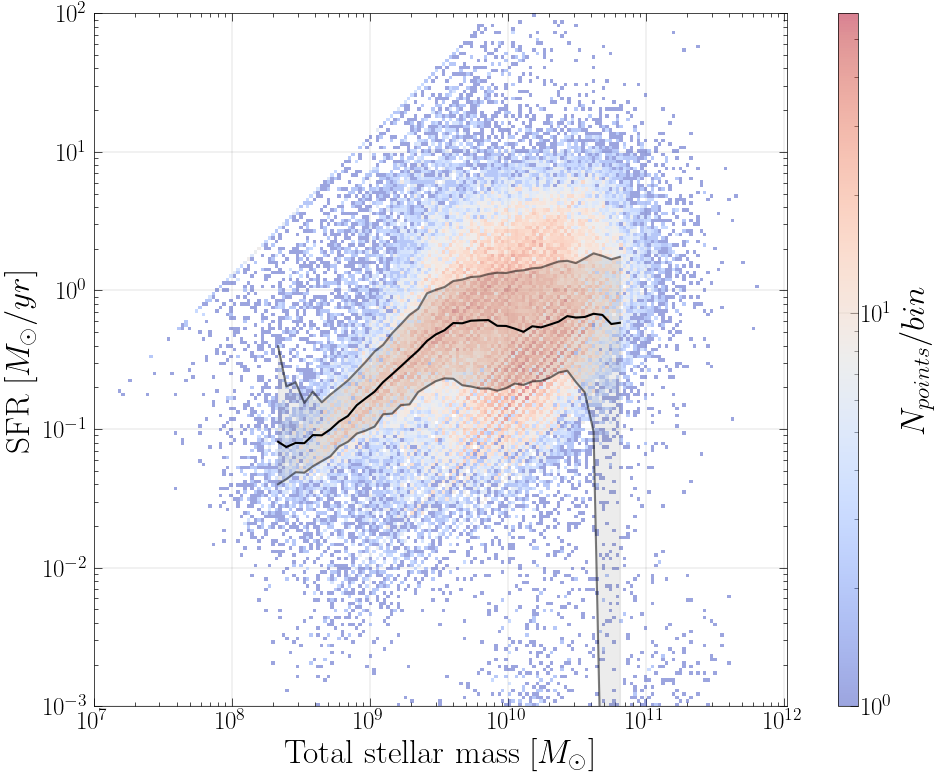

In [9]:
x_data = results['best.stellar.m_star']
y_data = results['best.sfh.sfr10Myrs']

fig, ax, statistics, hist = Plot(x_data, y_data, 'Total stellar mass $[M_\odot]$', 'SFR $[M_\odot/yr]$',
                                 x_min=1e7, y_min=1e-3, y_max=1e2, x_min_bins=2e8, x_max_bins=7e10);
print(f'bins occupation = {statistics[:,0].astype(int)}')

bins occupation = [ 232  295  372  444  496  636  732  786  935  991 1137 1223 1445 1501
 1825 1942 2040 2308 2521 2746 2865 2992 3171 3353 3687 3640 3870 4076
 4026 3988 3883 3677 3522 3241 2755 2499 2278 1942 1639 1317]


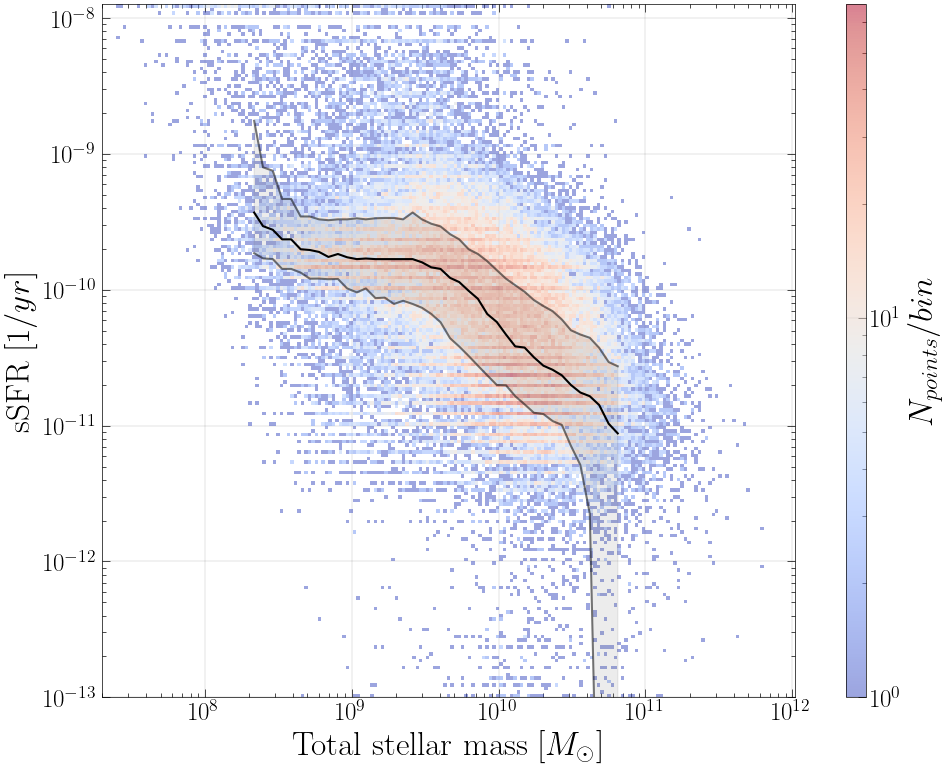

In [10]:
x_data = results['best.stellar.m_star']
y_data = results['best.sfh.sfr10Myrs']/results['best.stellar.m_star']
    
fig, ax, statistics, hist = Plot(x_data, y_data, 'Total stellar mass $[M_\odot]$', 'sSFR $[1/yr]$',
                                 x_min=2e7, y_min=1e-13, x_min_bins=2e8, x_max_bins=7e10);
print(f'bins occupation = {statistics[:,0].astype(int)}')

## sSFR vs Mass scatter plot and Age colormap

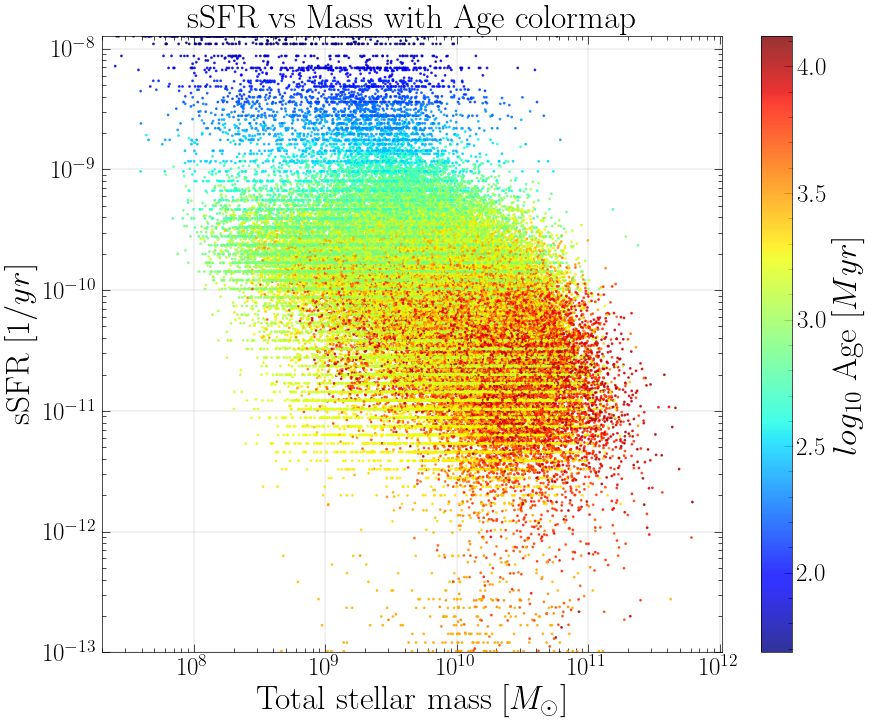

In [11]:
x_data = results['best.stellar.m_star']
y_data = results['best.sfh.sfr10Myrs']/results['best.stellar.m_star']
colormap_age = np.log10(results['best.stellar.age_m_star'])

x_min = 2e7
x_max = np.max(x_data)
y_min = 1e-13
y_max = np.max(y_data)
hist2d_nbins = 200

plt.title(f'sSFR vs Mass with Age colormap')
plt.scatter(x_data, y_data, c=colormap_age, cmap=plt.cm.jet, alpha=0.8, s=1)
plt.colorbar(label='$log_{{10}}$ Age $[Myr]$')

plt.xscale('log')
plt.yscale('log')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xlabel('Total stellar mass $[M_\odot]$')
plt.ylabel('sSFR $[1/yr]$');

bins occupation = [  409   265   264   402   487   607   782   906  1919  6334  8475 13446
 20160  7987  4537  3934  5165  5576  8199  2629]


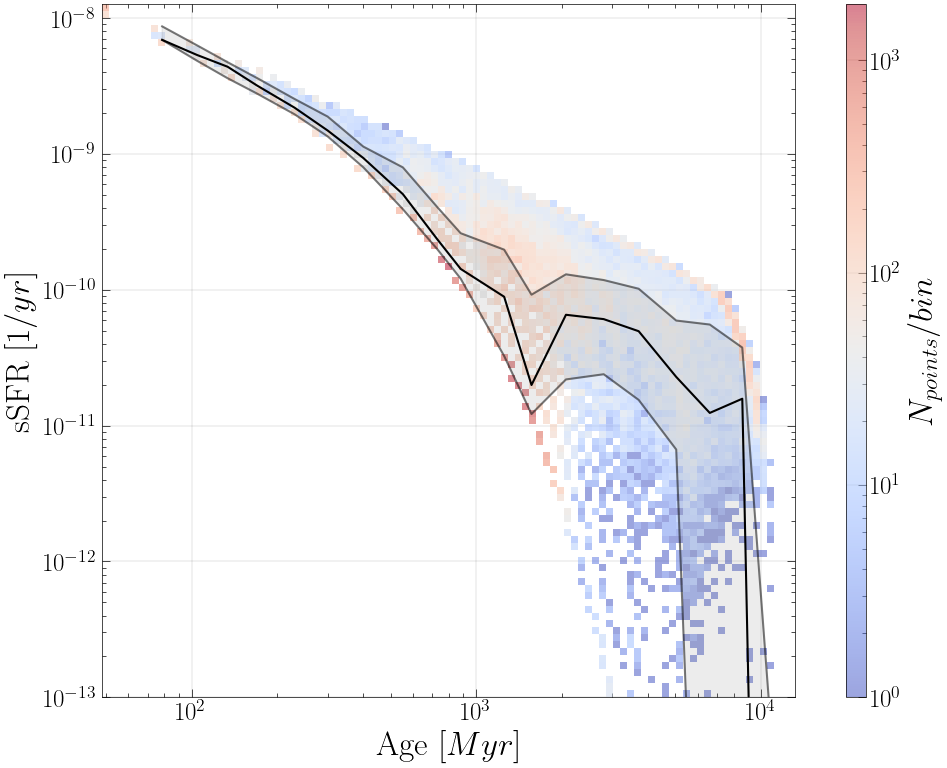

In [12]:
x_data = results['best.stellar.age_m_star']
y_data = results['best.sfh.sfr10Myrs']/results['best.stellar.m_star']
    
fig, ax, statistics, hist = Plot(x_data, y_data, 'Age $[Myr]$', 'sSFR $[1/yr]$', 
                                 y_min=1e-13, xbins=20, hist2d_nbins=100);
print(f'bins occupation = {statistics[:,0].astype(int)}')

## Searching for the minimum

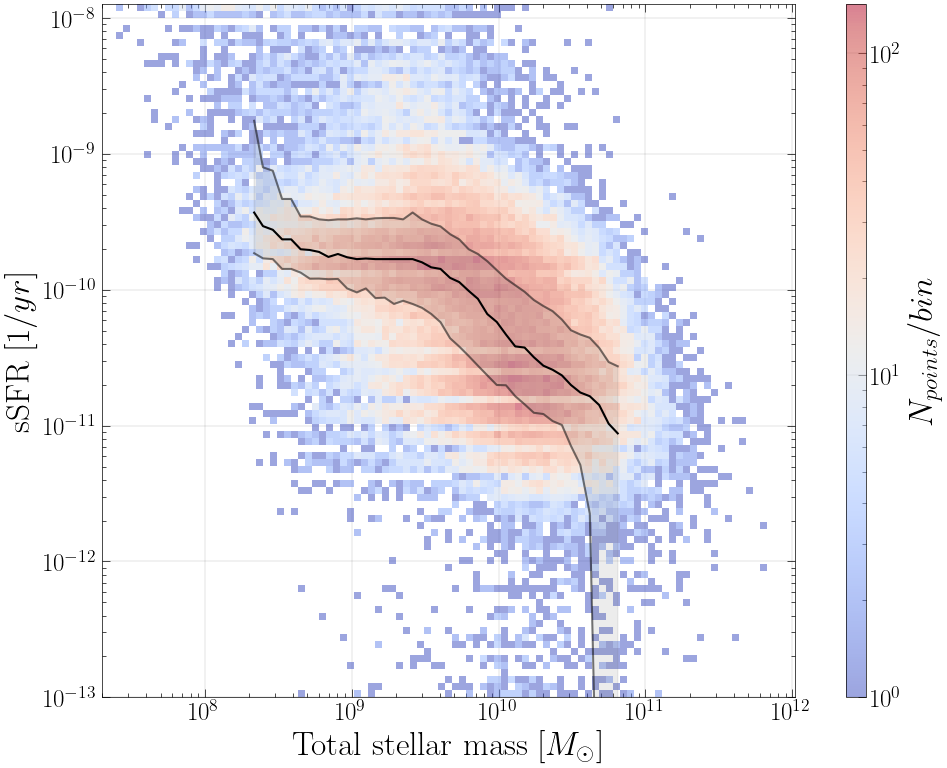

In [13]:
x_data = results['best.stellar.m_star']
y_data = results['best.sfh.sfr10Myrs']/results['best.stellar.m_star']
    
fig, ax, statistics, hist = Plot(x_data, y_data, 'Total stellar mass $[M_\odot]$', 'sSFR $[1/yr]$',
                                 x_min=2e7, y_min=1e-13, x_min_bins=2e8, x_max_bins=7e10, hist2d_nbins=100);

Text(0.5, 1.0, 'point density marginalized over sSFR')

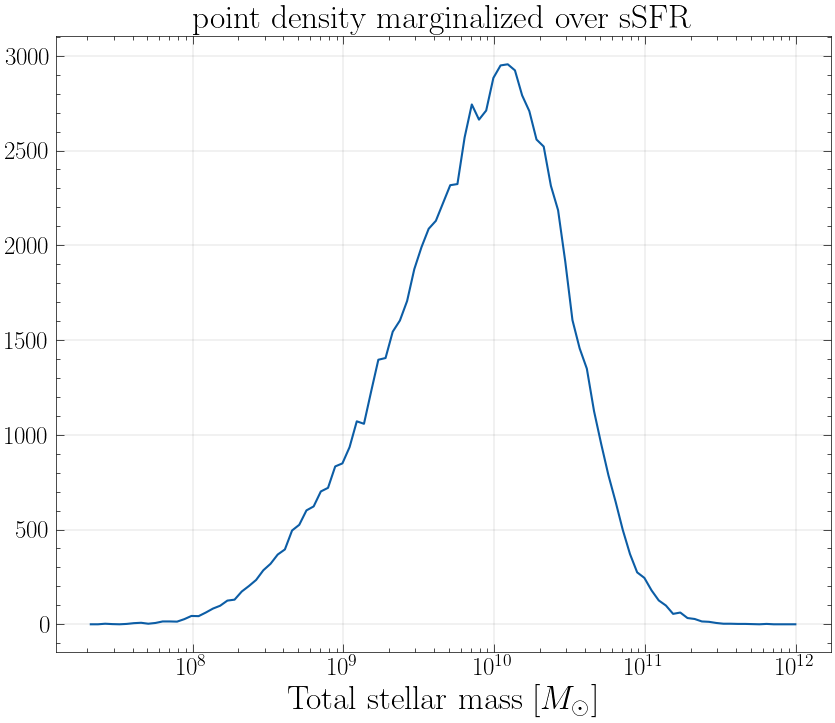

In [14]:
xbins_middle = (hist[1][:-1] + hist[1][1:])/2
marginalized_distr_over_sSFR = np.sum(hist[0], axis = 1)
plt.plot(xbins_middle, marginalized_distr_over_sSFR)
plt.xscale('log')
plt.xlabel('Total stellar mass $[M_\odot]$')
plt.title("point density marginalized over sSFR")

sSFR_min = 5.733802656789511e-11 = 10^(-10.242)


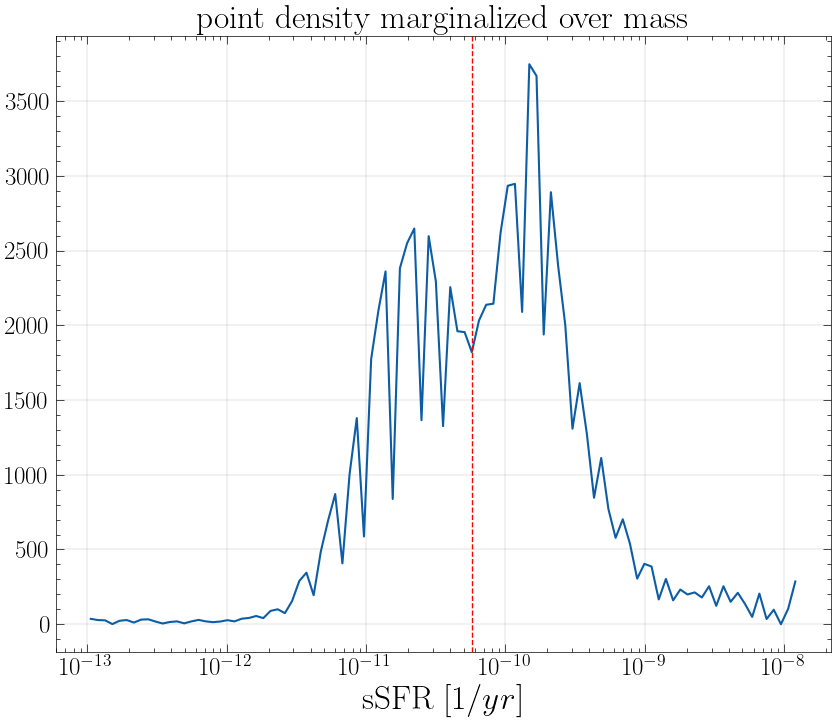

In [15]:
ybins_middle = (hist[2][:-1] + hist[2][1:])/2
marginalized_distr_over_mass = np.sum(hist[0], axis = 0)
plt.plot(ybins_middle, marginalized_distr_over_mass)
plt.xscale('log')
plt.xlabel('sSFR $[1/yr]$')
plt.title("point density marginalized over mass")
mask_for_min = ((ybins_middle > 4e-11) & (ybins_middle < 1e-10))

my_min = np.argsort(marginalized_distr_over_mass[mask_for_min])[0]
ybins_middle_min = ybins_middle[mask_for_min][my_min]
print(f'sSFR_min = {ybins_middle_min} = 10^({np.log10(ybins_middle_min):.3f})')
plt.axvline(ybins_middle_min, ls='--', lw=1, color='red');

# Lecture 6

## Main Sequence

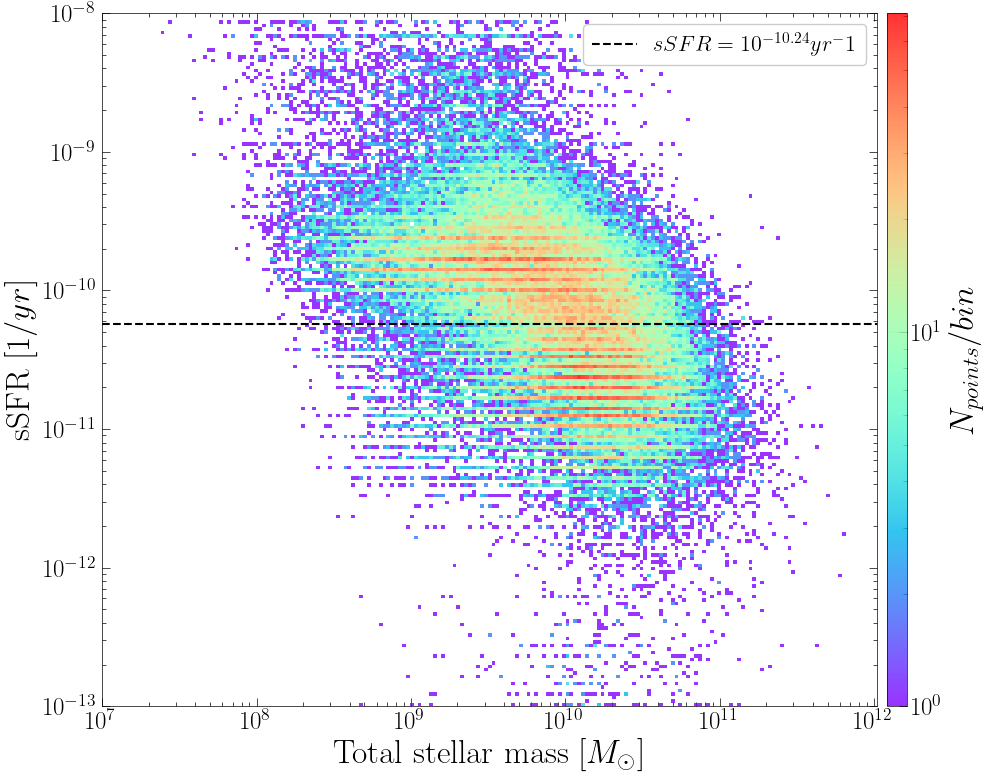

In [16]:
x_data = results['best.stellar.m_star']
y_data = results['best.sfh.sfr10Myrs']/results['best.stellar.m_star']

fig = plt.figure(figsize=(10,9))

# Bins limits in log
x_min = 7
x_max = np.log10(np.max(x_data))
y_min = -13
y_max = -8

binx = np.logspace(start=x_min, stop=x_max, num=200)
biny = np.logspace(start=y_min, stop=y_max, num=200)
hist = plt.hist2d(x_data, y_data, bins=(binx, biny), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.rainbow, alpha=0.8)
plt.axhline(ybins_middle_min, color='black', linestyle='--', label=f'$sSFR = 10^{{{np.log10(ybins_middle_min):.2f}}} yr^{-1}$')

plt.xscale('log')
plt.yscale('log')
plt.xlim(10**x_min, 10**x_max)
plt.ylim(10**y_min, 10**y_max)
plt.xlabel('Total stellar mass $[M_\odot]$')
plt.ylabel('sSFR $[1/yr]$')
plt.grid()
plt.legend()

cax = fig.add_axes([0.91, 0.11, 0.02, 0.77])
fig.colorbar(hist[3], cax=cax, label='$N_{points}/bin$');

### Now let's get the number of galaxies above and below the line and compute their fraction, in function of mass

In [17]:
# Whether to run this cell or not (it takes a while, but not that much)
run_MS_counter = True

#------------------------------------------------------
if run_MS_counter:
    # This is a mask on the already masked dataset: raw_data[mask][agn_mask]
    # It (will) select only AGNs, i.e. points (galaxies) above the red line
    MS_mask = np.zeros(len(results['best.stellar.m_star']), dtype=bool)

    for i in tqdm(range(len(results['best.stellar.m_star']))):
        x_temp =(results['best.stellar.m_star'][i])
        y_temp = (results['best.sfh.sfr10Myrs'][i]/results['best.stellar.m_star'][i])
        
        if y_temp>ybins_middle_min: MS_mask[i]=True

100%|██████████| 92483/92483 [00:00<00:00, 112321.03it/s]


In [18]:
#np.save('MS_mask_SupercomputerData', MS_mask)

In [19]:
n_MS = np.sum(MS_mask)
n_out_of_MS = len(results['best.stellar.m_star']) - n_MS
n_tot = len(results['best.stellar.m_star'])
print(n_MS, n_out_of_MS, n_tot)

47728 44755 92483


#### plot just to make sure i got it right

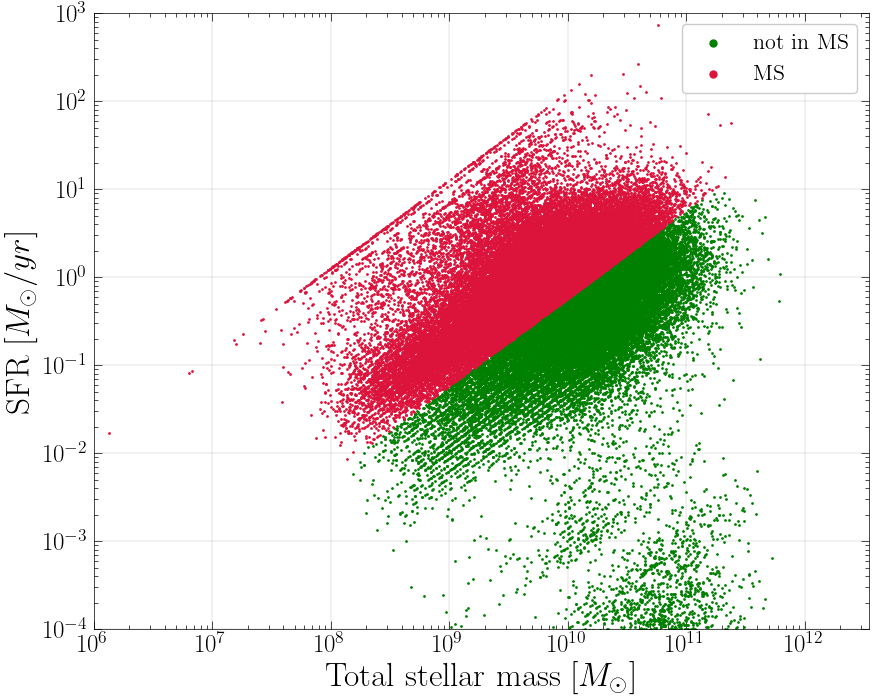

In [20]:
x_data = results['best.stellar.m_star']
y_data = results['best.sfh.sfr10Myrs']

fig, ax = plt.subplots(1, 1)

ax.scatter(x_data[~MS_mask], y_data[~MS_mask], s=1, color='green', label='not in MS')
ax.scatter(x_data[MS_mask], y_data[MS_mask], s=1, color='crimson', label='MS')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e6)
ax.set_ylim(1e-4, 1e3)


ax.set_xlabel('Total stellar mass $[M_\odot]$')
ax.set_ylabel('SFR $[M_\odot/yr]$')

ax.legend(markerscale=5);

In [21]:
bins_info = Bin_analysis(results['best.stellar.m_star'], MS_mask,
                         xbins=30, bin_type='log', x_min = 10**8, x_max = 10**(11.3)) 
print(bins_info.shape)

for i in (range(len(bins_info))):
    print( bins_info[i]['n_tot'])

(30,)
123
210
318
497
716
923
1277
1533
1834
2210
2633
3325
3702
4423
4909
5359
6023
6344
6979
6931
6590
6115
5054
4207
3228
2410
1609
1171
702
451


from astropy.visualization.hist import hist as fancyhist
histo_scott_rule = fancyhist(results['best.stellar.m_star'], bins="scott", histtype="step",density=True)
histo_freedman_rule = fancyhist(results['best.stellar.m_star'], bins="freedman", histtype="step",density=True)
#plt.xlim(-5,25)

print(len(histo_freedman_rule))

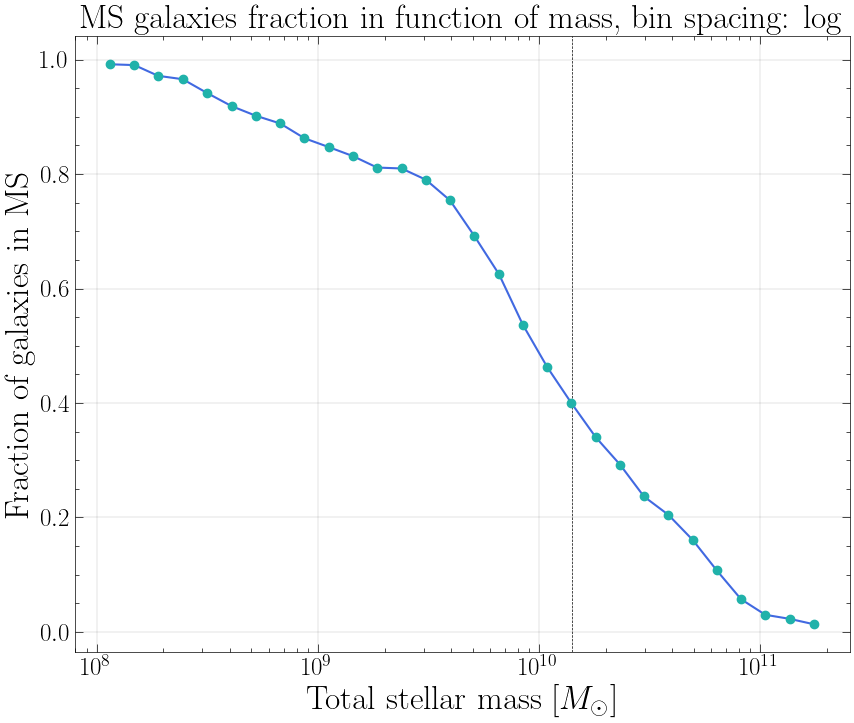

In [22]:
fig, ax = Bin_plotter(bins_info, x_key='mean', y_key='qty_frac',
            plt_err=True, err_type='mean_err',
            x_label='Total stellar mass $[M_\odot]$', y_label='Fraction of galaxies in MS',
            markersize=12, linestyle='-',
            ecolor='red', color='royalblue', markerfacecolor='lightseagreen', markeredgecolor='lightseagreen',
            bad_bins=list(range(0)), title = "MS galaxies fraction in function of mass, bin spacing: log");

ax.axvline(1.4*10**10, ls='--', lw=0.5, c='black', zorder=0)

## Galaxy Environment

In [23]:
from astropy.coordinates import FK5, SkyCoord
import astropy.constants as astroconst
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

In [24]:
# We need to reopen the .fits file, since Astropy doesn't like that we converted it to a Pandas dataframe
data = Table.read('SDSS_LAB2024_photometry.fits', format='fits') 

In [25]:
c = astroconst.c #m/s
c_km_s = c*u.km/(1000*u.m)
print(c_km_s)

299792.458 km / s


### cylinder definition: we could also try different cylinders and see how the structures we see change!!

In [26]:
radius = 500*u.kpc
depth = 1000*u.km/u.s 

In [27]:
# Whether to run this cell or not (it takes a while)
# The results of this cell are already in SDSS_environment.fits (used in the cell below)
compute_surface_density = False

#-----------------------------------------------------
if compute_surface_density:

    NEIcoords = SkyCoord(ra=data['ra']*u.deg, dec=data['dec']*u.deg)
    NEIredshift = data['redshift']

    n_galaxies_cyl = np.zeros(len(data['id']))

    for gal in tqdm(range(0, len(data['id']))):
        PRIcoords = SkyCoord(ra=data['ra'][gal]*u.deg, dec=data['dec'][gal]*u.deg)
        PRIredshift = data['redshift'][gal]
        
        # Obtain a separation of all galaxies from the primary in units of arcseconds
        Separation = NEIcoords.separation(PRIcoords).to(u.arcsec)
        # Convert it to kpc 
        ang_1kpc = cosmo.arcsec_per_kpc_proper(PRIredshift)
        Separation = Separation/ang_1kpc
        
        # Now we also want the separation in velocity (in km/s)
        Sep_vel = (NEIredshift-PRIredshift)*c_km_s / (1+PRIredshift)
        
        # Define the cylinder
        mask_base = Separation < radius
        mask_depth = (Sep_vel < depth) & (Sep_vel > - depth)
        
        mask_cylinder = mask_base & mask_depth
        n_galaxies_cyl[gal] = mask_cylinder.sum()
        
    surface_density = n_galaxies_cyl / (np.pi*radius**2)
    print(surface_density) # ".value" to remove the Astropy units

In [28]:
# Export the surface-density values
#tabout = Table((data['id'], data['ra'], data['dec'], surface_density), names=('id', 'ra', 'dec', 'surface_density'))
#tabout.write('SDSS_environment_depth_1000.fits', overwrite=True)

In [29]:
# Import the surface-density values
surface_density = np.array(Table.read('SDSS_environment_depth_1000.fits', format='fits')['surface_density'], dtype='float')
surface_density

array([7.63943727e-06, 1.27323954e-06, 1.27323954e-06, ...,
       2.54647909e-06, 1.27323954e-06, 2.54647909e-06])

### Plot

Text(0.5, 0, 'density')

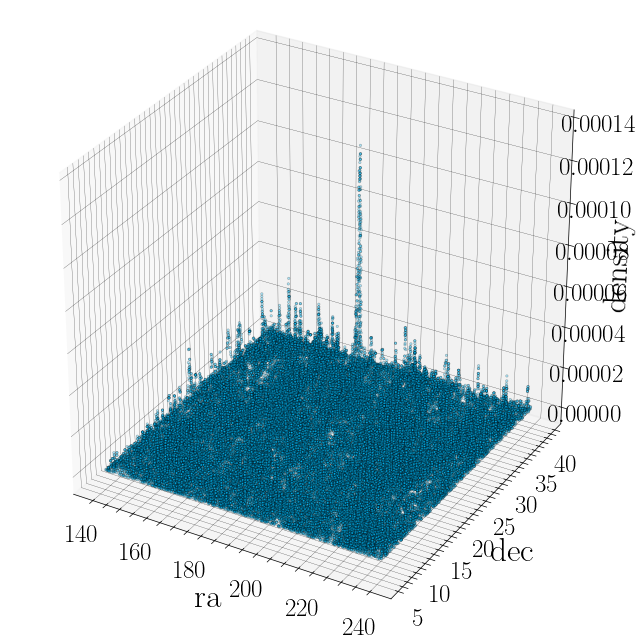

In [30]:
fig, ax = plt.subplots(subplot_kw={'projection':'3d'})

ax.set_box_aspect([1, 1, 1])

ax.scatter(data['ra'], data['dec'], surface_density, 'o', s=3, edgecolor='black', linewidth=0.4, color='deepskyblue', alpha=0.3)

ax.set_xlabel('ra')
ax.set_ylabel('dec')
ax.set_zlabel('density')

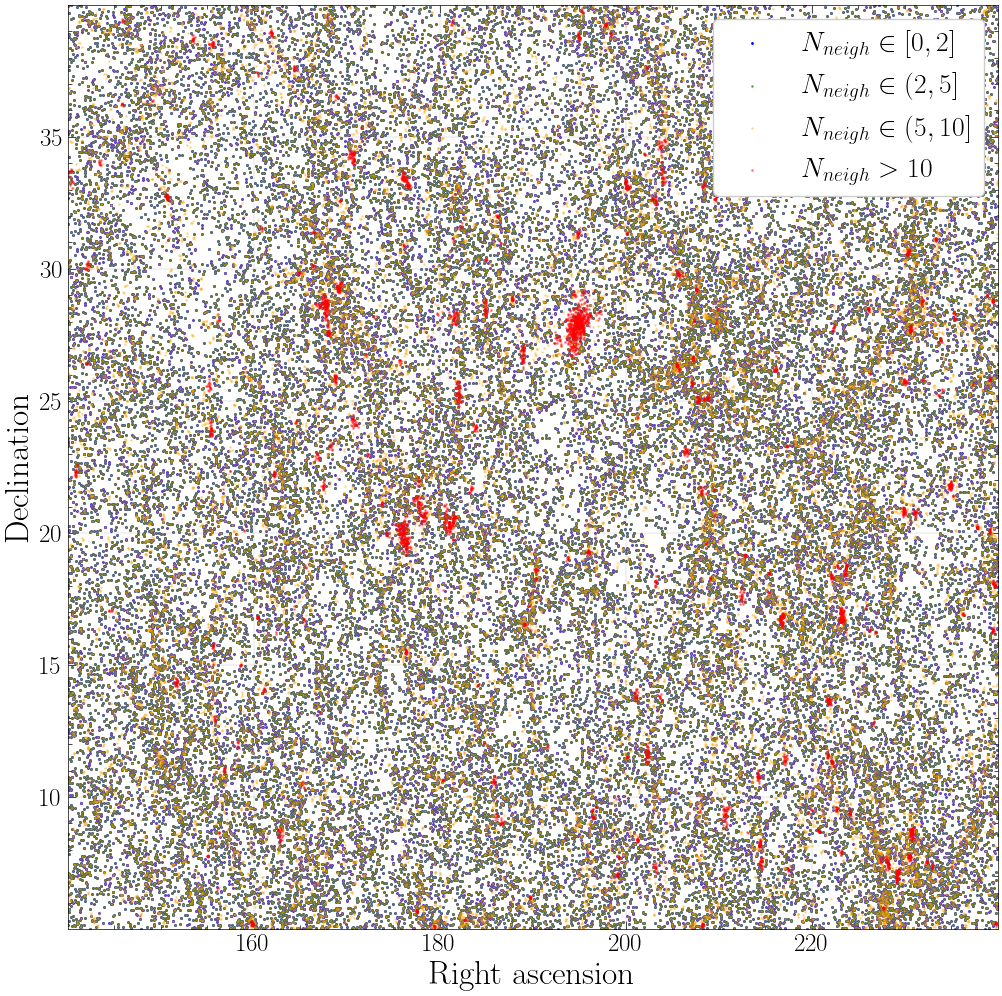

In [31]:
n_galaxies_cyl = surface_density*np.pi*radius.value**2

plt.figure(figsize=(12,12))

mask = n_galaxies_cyl<=2
plt.scatter(data['ra'][mask], data['dec'][mask], s=1, color='blue', alpha=1, label='$N_{neigh} \in [0,2]$')

mask = np.logical_and(n_galaxies_cyl<2, n_galaxies_cyl<=5)
plt.scatter(data['ra'][mask], data['dec'][mask], s=1, color='green', alpha=0.5, label='$N_{neigh} \in (2,5]$')

mask = np.logical_and(n_galaxies_cyl<5, n_galaxies_cyl<=10)
plt.scatter(data['ra'][mask], data['dec'][mask], s=1, color='orange', alpha=0.3, label='$N_{neigh} \in (5,10]$')

mask = n_galaxies_cyl>10
plt.scatter(data['ra'][mask], data['dec'][mask], s=1, color='red', alpha=0.4, label='$N_{neigh} > 10$')

plt.xlim(np.min(data['ra']), np.max(data['ra']))
plt.ylim(np.min(data['dec']), np.max(data['dec']))
plt.xlabel('Right ascension')
plt.ylabel('Declination')


'''IF ONE WANTED TO PUT THE BOX WITH CYLINDER DIMENTIONS:
radius_dimentionless = radius / u.kpc
depth_dimentionless = depth /(u.km/u.s)
textstr = '\n'.join(('cylinder of dimensions: ', 
    r'$radius (kpc)=%.2f$' % (radius_dimentionless, ),
    r'$depth (km/s)=%.2f$' % (depth_dimentionless, )))

props = dict(boxstyle='round', facecolor='white', alpha=1)

# place a text box in upper left in axes coords
plt.text(0.81, 0.85, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
'''


lgnd = plt.legend(loc='upper right', fontsize=20)
#for marker in lgnd.legend_handles:
#   marker._sizes = [40]

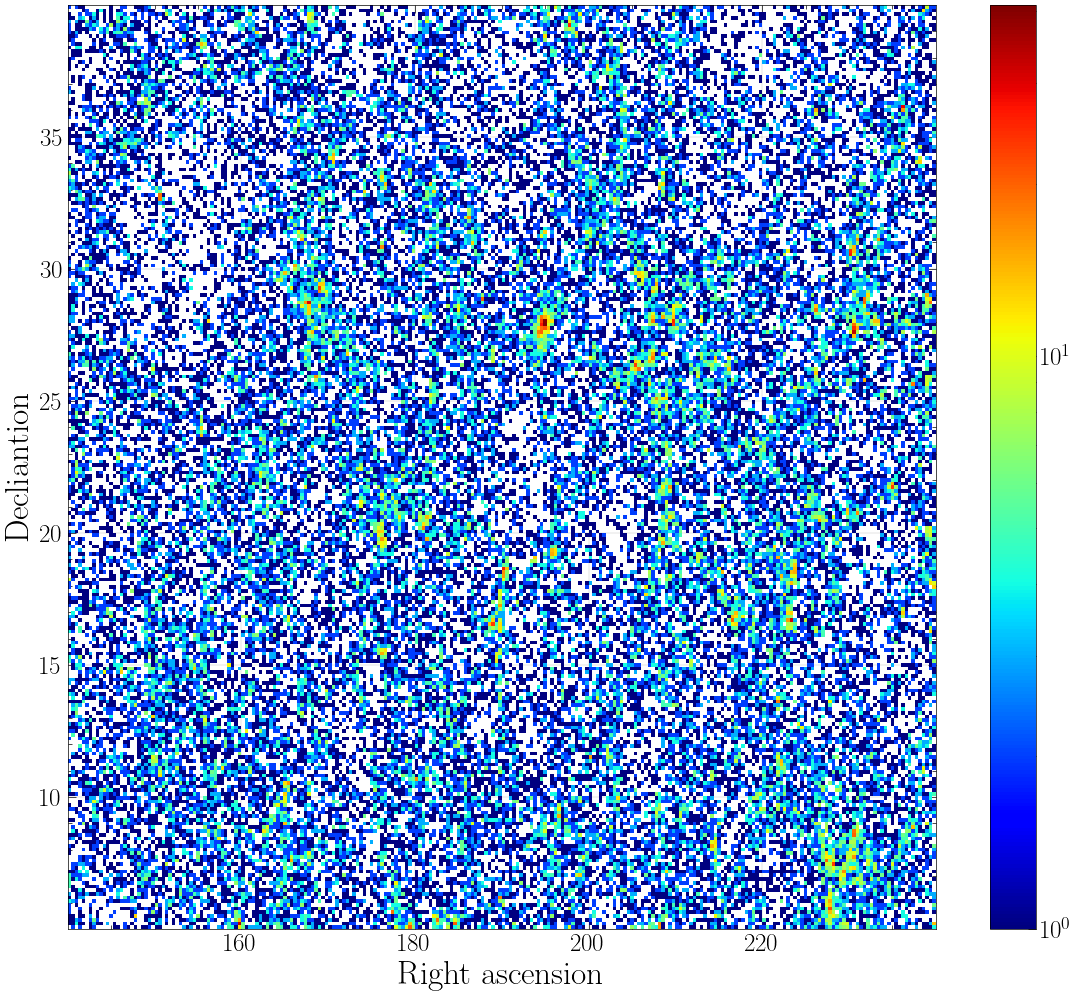

In [32]:
plt.figure(figsize=(14,12))

hist = plt.hist2d(data['ra'], data['dec'], bins=(250, 250), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
plt.xlabel('Right ascension')
plt.ylabel('Decliantion')
fig.colorbar(hist[3])

### Dependencies

bins occupation = [39282 19628 16977  7087  5343  2465  1055   424   130    92]


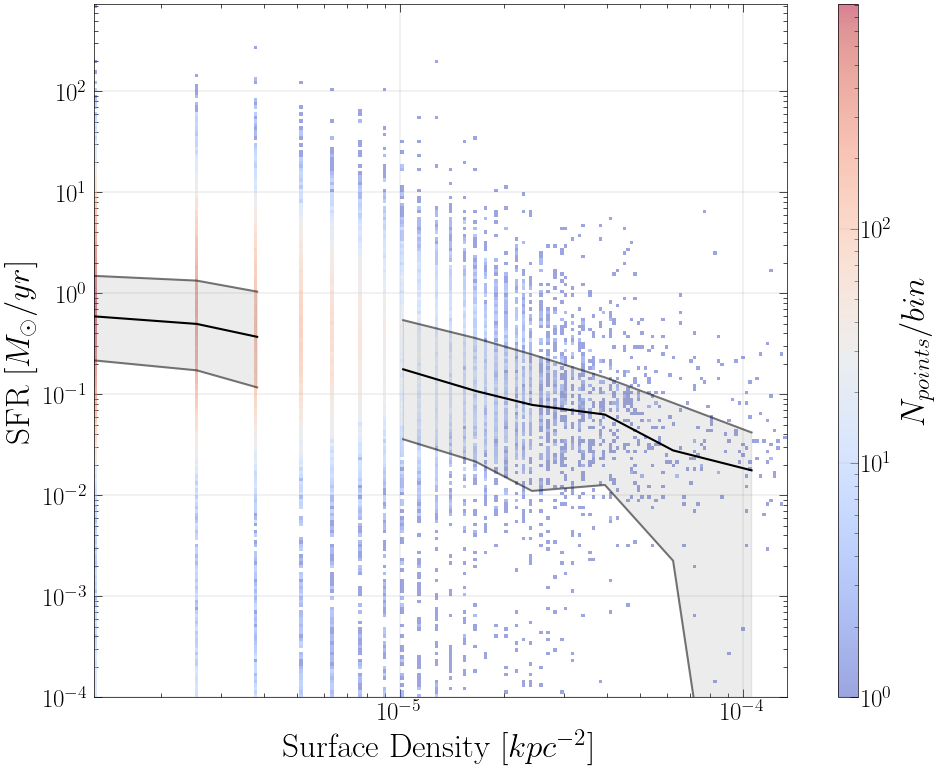

In [33]:
x_data = surface_density
y_data = results['best.sfh.sfr10Myrs']

fig, ax, statistics, hist = Plot(x_data, y_data, 'Surface Density $[kpc^{-2}]$', 'SFR $[M_\odot/yr]$', xbins=10, y_min=1e-4);
print(f'bins occupation = {statistics[:,0].astype(int)}')

bins occupation = [39282 19628 16977  7087  5343  2465  1055   424   130    92]


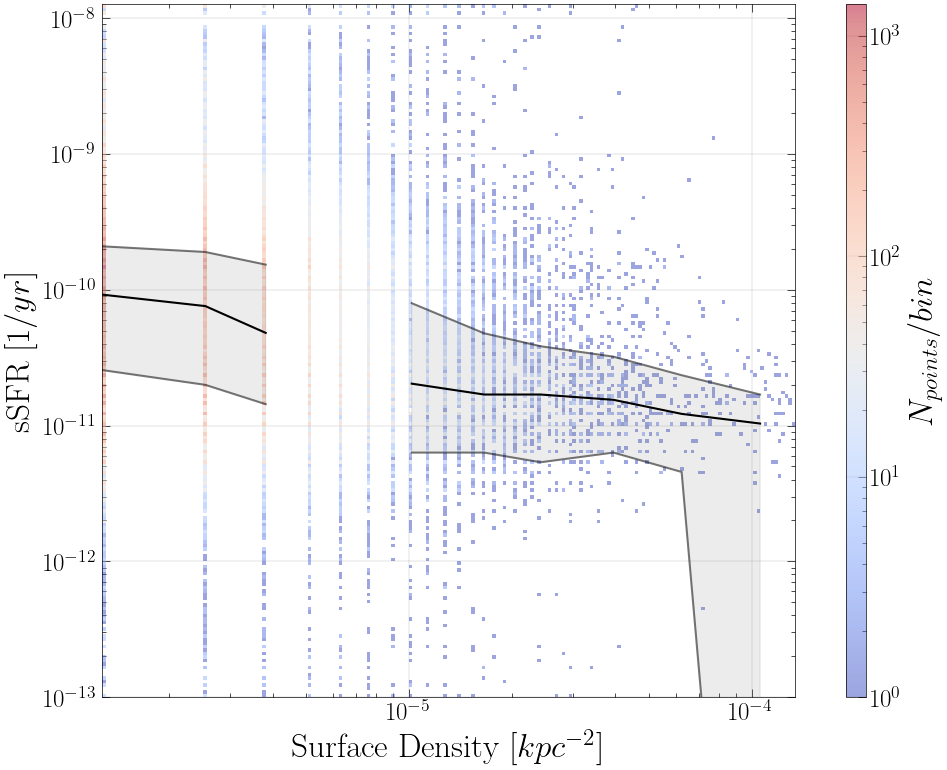

In [34]:
x_data = surface_density
y_data = results['best.sfh.sfr10Myrs']/results['best.stellar.m_star']

fig, ax, statistics, hist = Plot(x_data, y_data, 'Surface Density $[kpc^{-2}]$', 'sSFR $[1/yr]$', xbins=10, y_min=1e-13);
print(f'bins occupation = {statistics[:,0].astype(int)}')

bins occupation = [39282 19628 16977  7087  5343  2465  1055   424   130    92]


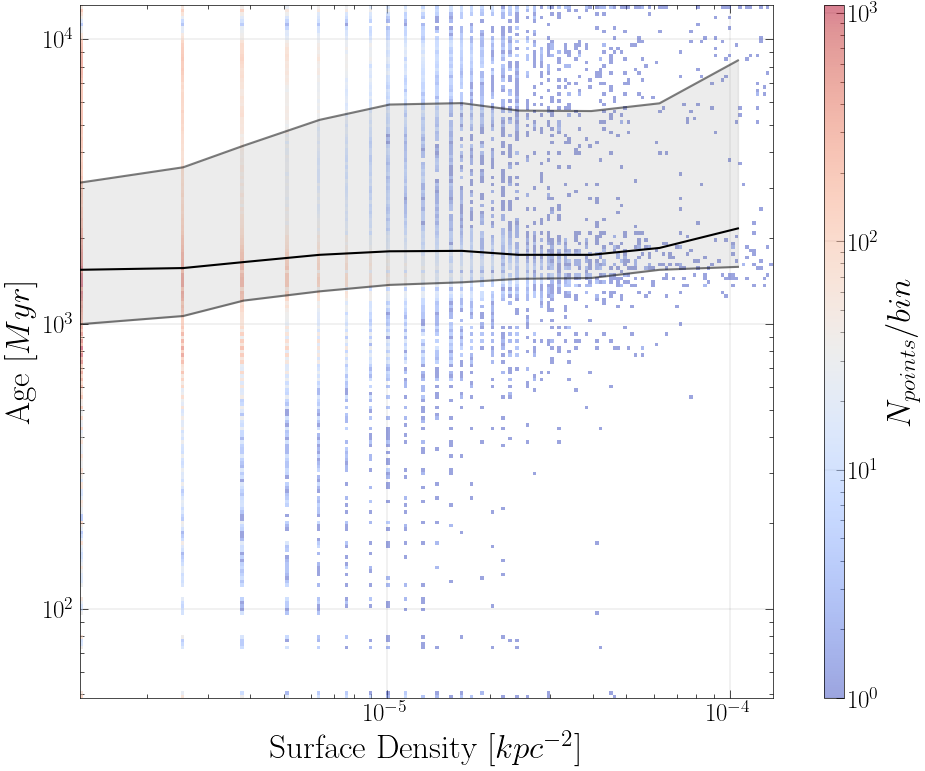

In [35]:
x_data = surface_density
y_data = results['best.stellar.age_m_star']

fig, ax, statistics, hist = Plot(x_data, y_data, 'Surface Density $[kpc^{-2}]$', 'Age $[Myr]$', xbins=10);
print(f'bins occupation = {statistics[:,0].astype(int)}')

bins occupation = [39282 19628 16977  7087  5343  2465  1055   424   130    92]


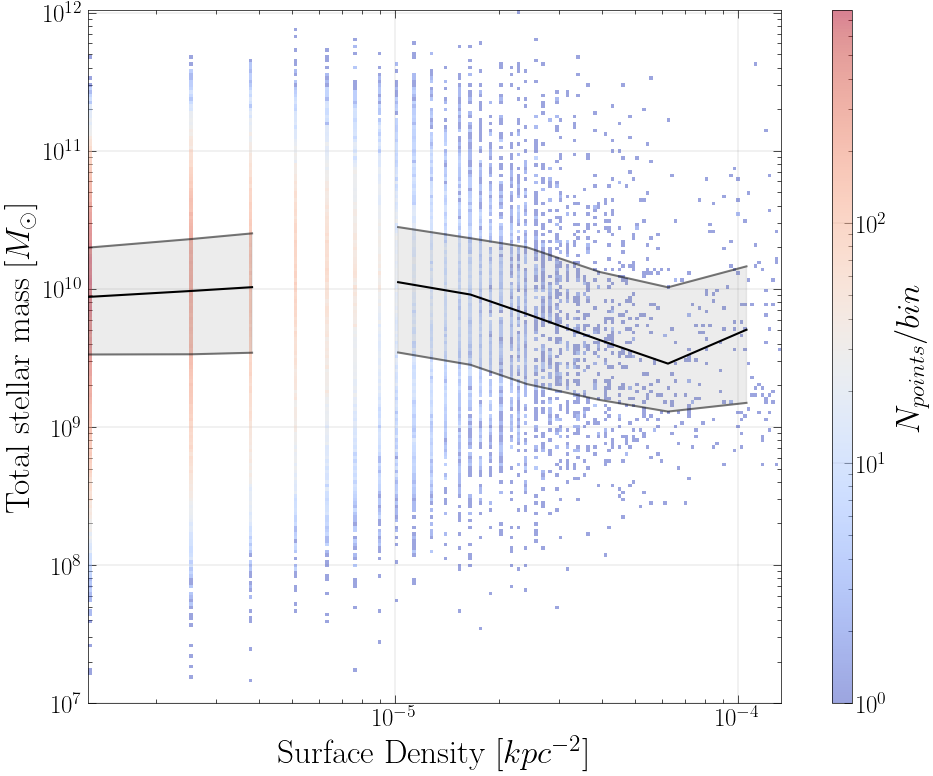

In [36]:
x_data = surface_density
y_data = results['best.stellar.m_star']

fig, ax, statistics, hist = Plot(x_data, y_data, 'Surface Density $[kpc^{-2}]$', 'Total stellar mass $[M_\odot]$', xbins=10, y_min=1e7);
print(f'bins occupation = {statistics[:,0].astype(int)}')

# Lecture 7

## Metallicity

In [37]:
data = Table.read('SDSS_LAB2024_spectroscopy.fits', format='fits')
data = data.to_pandas()
data

id          Ra        Dec            SpecObjID  \
0      1237657873254907919  140.153626  39.308208  1056110100969711616   
1      1237657873254973544  140.325684  39.456471  1056110375847618560   
2      1237654880726286453  190.287293   5.309674   952651549304186880   
3      1237654880727728243  193.587524   5.282654   954879439135598592   
4      1237654880728842356  196.179871   5.124015   956053988573210624   
...                    ...         ...        ...                  ...   
92478  1237654881812545849  219.128952   5.382636  2058168727995705344   
92479  1237654881814511891  223.538071   5.049211  2060422194793572352   
92480  1237651823782396044  214.389114   5.217847   656554436428064768   
92481  1237651823782985830  215.724396   5.183447   657669890873780224   
92482  1237651823783313552  216.423401   5.139604   657683085013313536   

       oii_3726_flux  oii_3726_flux_err  oii_3729_flux  oii_3729_flux_err  \
0         101.519500           7.398387     140.663100           7.543258   
1          38.902310           4.698286      43.133400           4.939773   
2          10.251290           4.456565      27.182910           4.610123   
3          17.041710           7.241267      29.625190           7.116340   
4          88.530870           4.791603     100.263500           4.959826   
...              ...                ...            ...                ...   
92478       6.568196           5.159519       4.854383           5.068860   
92479       0.526393           8.585512      -1.139811           8.454541   
92480      23.171340           4.409194      29.234810           4.638111   
92481      74.059460           4.793346      59.283220           4.838350   
92482      49.073820           4.356719      52.939790           4.539048   

       h_beta_flux  h_beta_flux_err  oiii_5007_flux  oiii_5007_flux_err  \
0       151.599239         4.972585      104.966700            3.483613   
1        54.816254         4.419355       18.775540            2.549214   
2        51.681798        15.083097       23.813960            2.912106   
3       107.328879        18.837620       29.908130            4.471506   
4       114.449956         3.808321       55.175960            2.417139   
...            ...              ...             ...                 ...   
92478    53.910157        24.596951       -2.758879            2.225314   
92479    15.348567      -777.892867        1.975070            2.705857   
92480    74.191878         7.748188       17.575280            3.023975   
92481   169.463578         4.029014       31.102540            2.454101   
92482    92.885380         3.741976       15.621820            2.207598   

       h_alpha_flux  h_alpha_flux_err  nii_6584_flux  nii_6584_flux_err  \
0        454.801161          5.767852     127.769300           2.672537   
1        129.358509          2.765097      35.350590           1.867918   
2         63.133956          5.142882      17.806730           2.474831   
3        150.623169          9.592171      69.223010           5.355443   
4        257.938248          3.805013      54.351610           1.815738   
...             ...               ...            ...                ...   
92478     60.120945          9.137989      -0.470011           1.846521   
92479     19.204711          5.814079       0.766059           1.707300   
92480    171.301288          5.229351      74.111350           3.562458   
92481    571.920179          5.911172     228.338300           3.343860   
92482    259.282643          3.740093      74.735720           2.207302   

       sii_6717_flux  sii_6717_flux_err  sii_6731_flux  sii_6731_flux_err  \
0         106.806100           2.863982      73.735440           2.606843   
1          29.757880           1.816272      19.586350           1.636298   
2          14.909740           2.595782       4.719933           3.016939   
3          27.537210           4.663846      16.293380           4.523975   
4          55.005020   

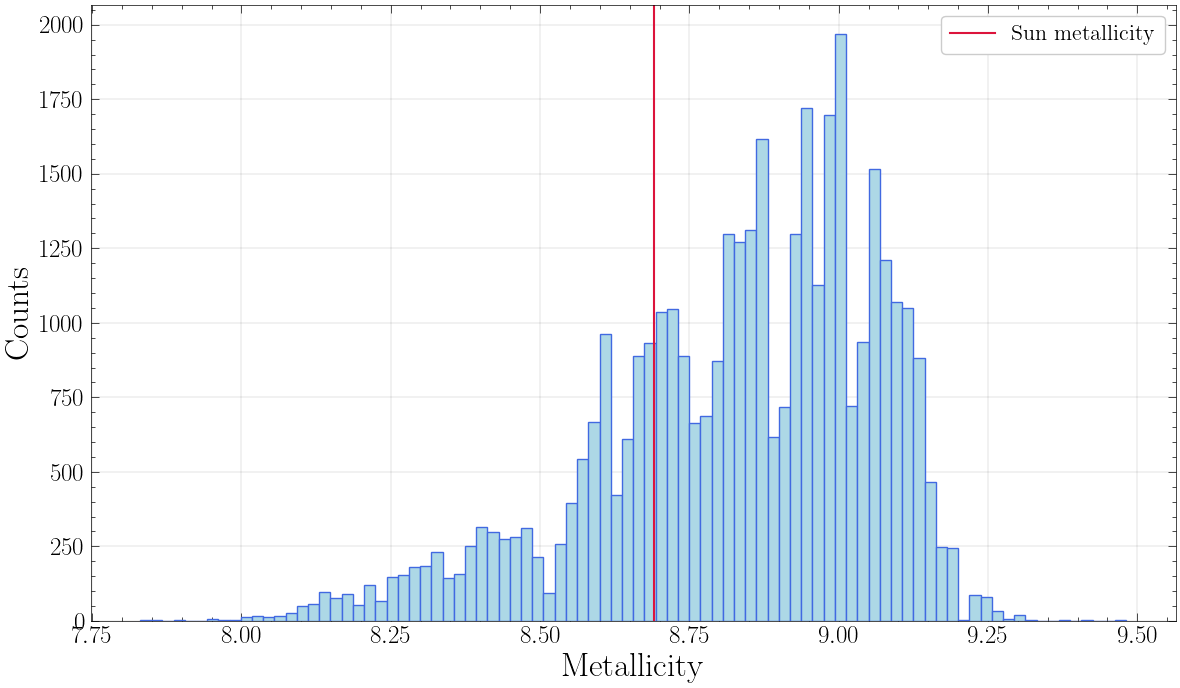

In [38]:
from astropy.visualization.hist import hist as fancyhist

mask = data['log_oh']>-4

plt.figure(figsize=(14,8))
fancyhist(data['log_oh'][mask], bins="freedman", color='lightblue', edgecolor='royalblue');
#plt.hist(data['log_oh'][mask], bins=70, color='lightblue', edgecolor='royalblue');
plt.axvline(8.69, color='crimson', label='Sun metallicity')
plt.xlabel('Metallicity')
plt.ylabel('Counts')
plt.legend();

bins occupation = [  74  118  126   78  149  144  230  246  313  212  286  438  422  393
  431  163  407  702 1043 1053  838 1332 1536 1507 1019 1047 1882 1916
 2179 1013 1699 2229 2446 2332 1661 1868 1865 1293  675  326]


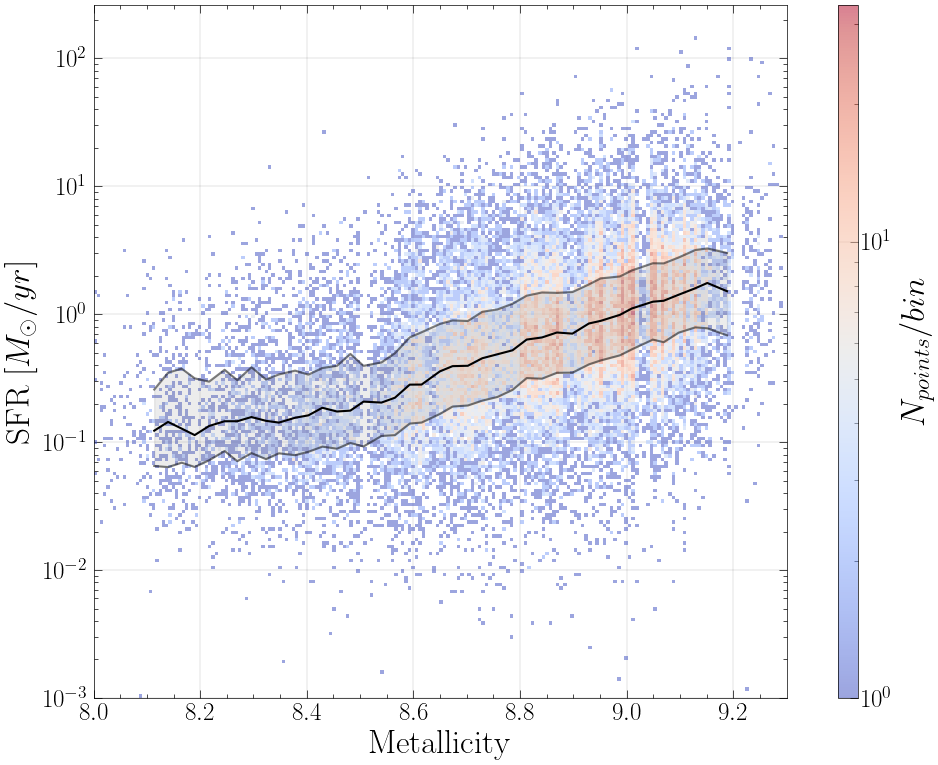

In [39]:
x_data = data['log_oh'][mask]
y_data = results['best.sfh.sfr10Myrs'][mask]

fig, ax, statistics, hist = Plot(x_data, y_data, 'Metallicity', 'SFR $[M_\odot/yr]$', 
                                 xlog=False, x_min=8, x_max=9.3, y_min=1e-3, x_min_bins=8.1, x_max_bins=9.2);
print(f'bins occupation = {statistics[:,0].astype(int)}')

bins occupation = [  74  118  126   78  149  144  230  246  313  212  286  438  422  393
  431  163  407  702 1043 1053  838 1332 1536 1507 1019 1047 1882 1916
 2179 1013 1699 2229 2446 2332 1661 1868 1865 1293  675  326]


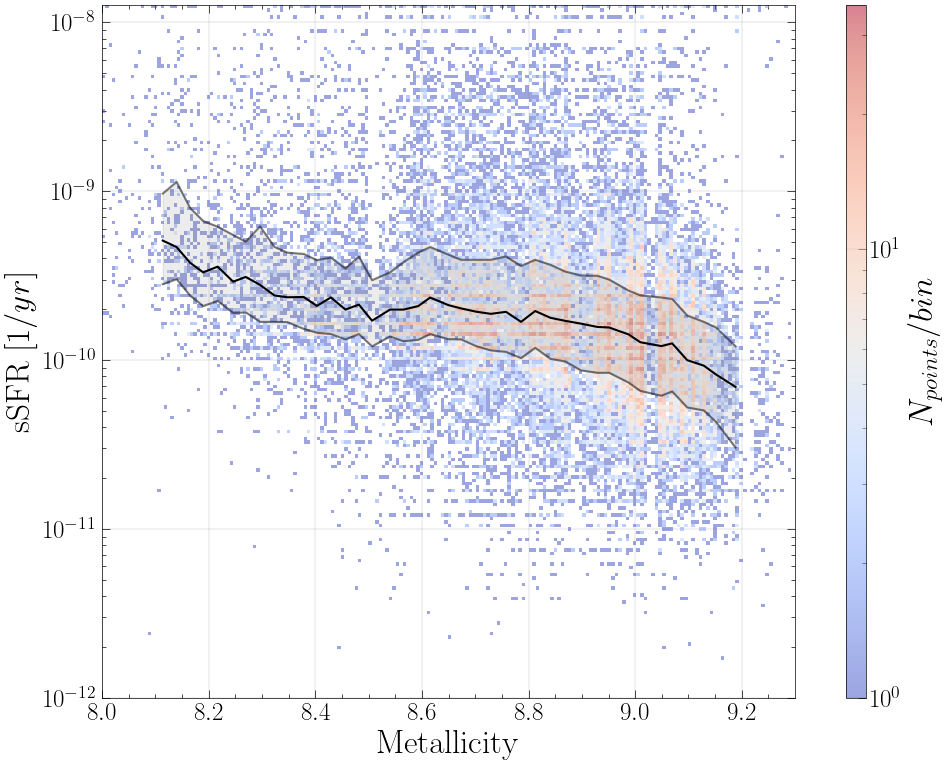

In [40]:
x_data = data['log_oh'][mask]
y_data = results['best.sfh.sfr10Myrs'][mask]/results['best.stellar.m_star'][mask]

fig, ax, statistics, hist = Plot(x_data, y_data, 'Metallicity', 'sSFR $[1/yr]$', 
                                 xlog=False, x_min=8, x_max=9.3, y_min=1e-12, x_min_bins=8.1, x_max_bins=9.2);
print(f'bins occupation = {statistics[:,0].astype(int)}')

bins occupation = [  74  118  126   78  149  144  230  246  313  212  286  438  422  393
  431  163  407  702 1043 1053  838 1332 1536 1507 1019 1047 1882 1916
 2179 1013 1699 2229 2446 2332 1661 1868 1865 1293  675  326]


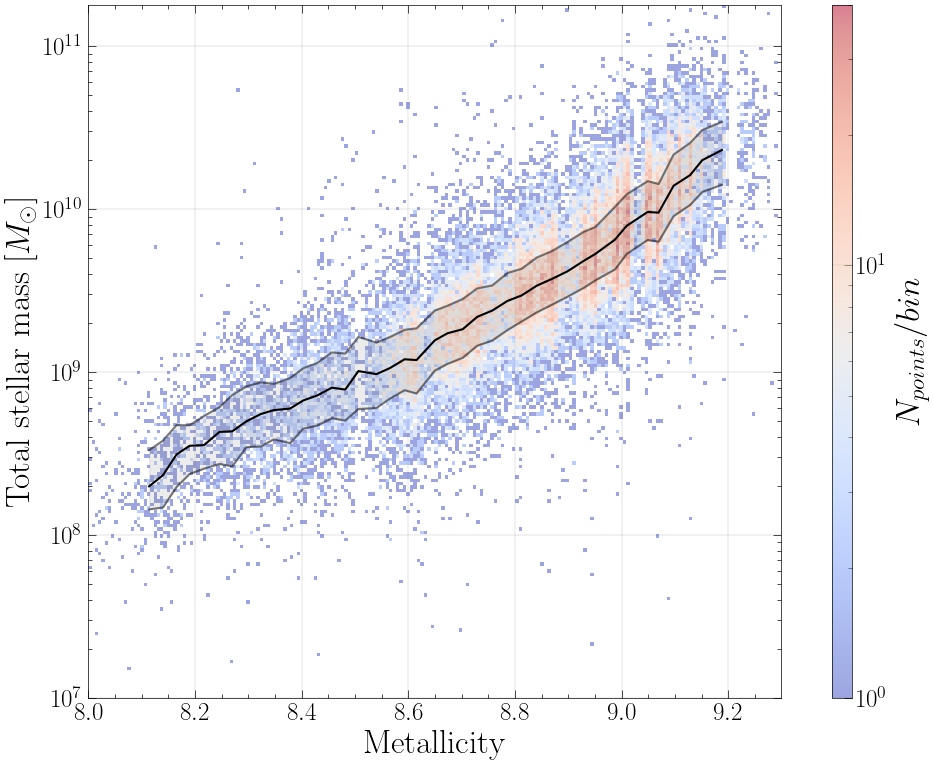

In [41]:
x_data = data['log_oh'][mask]
y_data = results['best.stellar.m_star'][mask]

fig, ax, statistics, hist = Plot(x_data, y_data, 'Metallicity', 'Total stellar mass $[M_\odot]$', 
                                 xlog=False, x_min=8, x_max=9.3, y_min=1e7, x_min_bins=8.1, x_max_bins=9.2);
print(f'bins occupation = {statistics[:,0].astype(int)}')

bins occupation = [  74  118  126   78  149  144  230  246  313  212  286  438  422  393
  431  163  407  702 1043 1053  838 1332 1536 1507 1019 1047 1882 1916
 2179 1013 1699 2229 2446 2332 1661 1868 1865 1293  675  326]


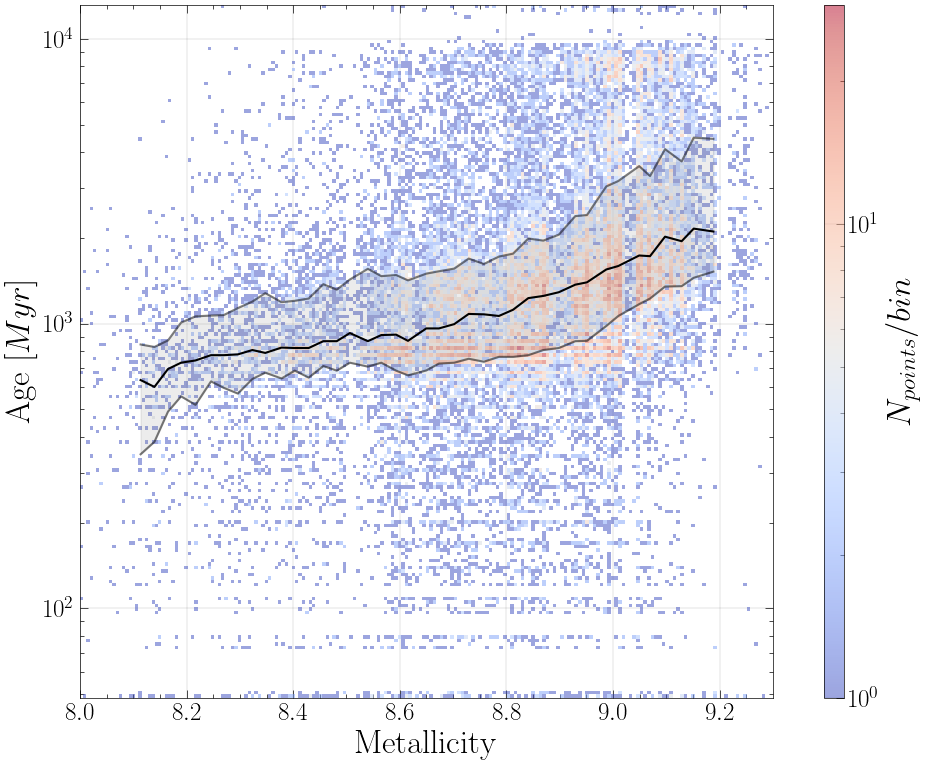

In [42]:
x_data = data['log_oh'][mask]
y_data = results['best.stellar.age_m_star'][mask]

fig, ax, statistics, hist = Plot(x_data, y_data,  'Metallicity', 'Age $[Myr]$', 
                                 xlog=False, x_min=8, x_max=9.3, x_min_bins=8.1, x_max_bins=9.2);
print(f'bins occupation = {statistics[:,0].astype(int)}')

## AGNs   ----> know that they don't have metallicity in the cataloge

In [43]:
# This is a mask on the raw dataset (S/N > 5 for every emission line)
mask = ((data['nii_6584_flux']/data['nii_6584_flux_err'] > 5) & 
       (data['oiii_5007_flux']/data['oiii_5007_flux_err'] > 5) &
       (data['h_alpha_flux']/data['h_alpha_flux_err'] > 5) &
       (data['h_beta_flux']/data['h_beta_flux_err'] > 5))

mask = np.array(mask)

In [44]:
def model(x):
    return 0.61 / (x-0.05) + 1.3

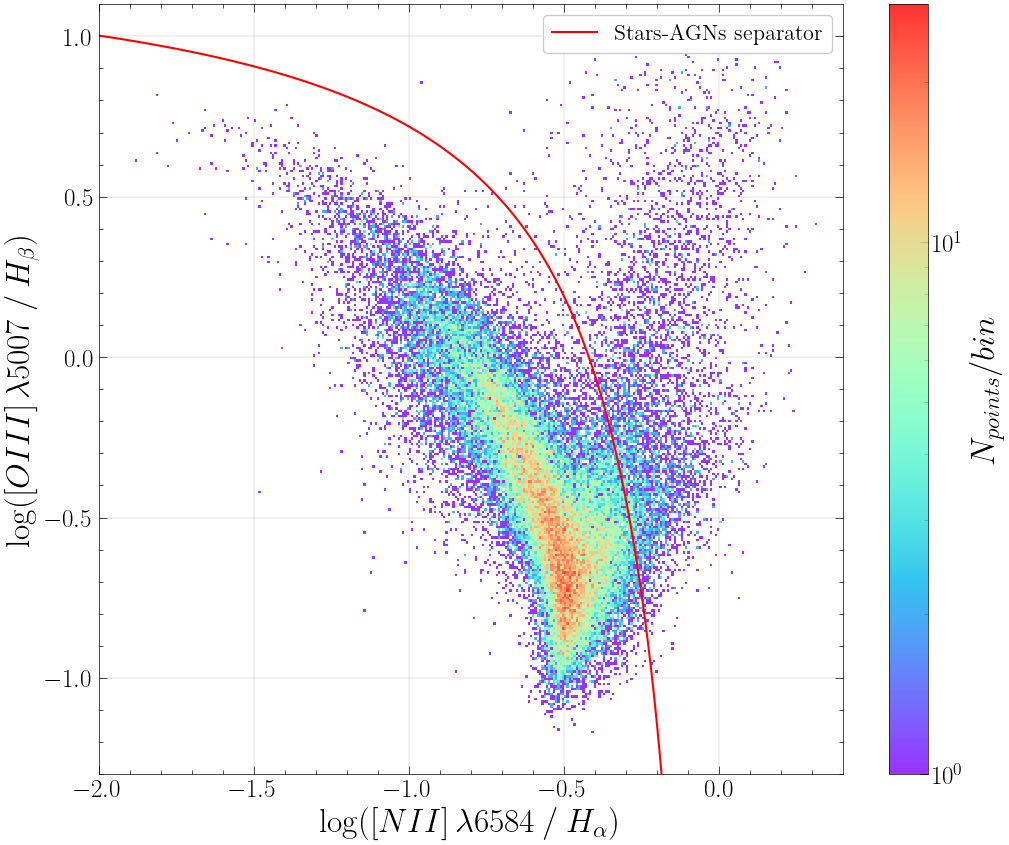

In [45]:
# Data (masked)
plt.figure(figsize=(12, 10))

x_data = np.log10(data['nii_6584_flux'][mask]/data['h_alpha_flux'][mask])
y_data = np.log10(data['oiii_5007_flux'][mask]/data['h_beta_flux'][mask])

binx = np.linspace(np.min(x_data), np.max(x_data), num=300)
biny = np.linspace(np.min(y_data), np.max(y_data), num=300)
hist = plt.hist2d(x_data, y_data, bins=(binx, biny), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.rainbow, alpha=0.8)

#-------------------------------------------
# Red line
model_r_bound = 0.05 # Analytic bound of the model (divergence point)
x_dense = np.linspace(-2, model_r_bound, int(10000), endpoint=False) 

plt.plot(x_dense, model(x_dense), color='red', label='Stars-AGNs separator')
plt.xlim(-2, 0.4)
plt.ylim(-1.3, 1.1)
plt.xlabel('$\log([NII] \, \lambda6584 \: / \: H_\\alpha)$')
plt.ylabel('$\log([OIII] \, \lambda5007 \: / \: H_\\beta)$')
plt.colorbar(hist[3], label='$N_{points}/bin$')
plt.legend();

In [46]:
# Whether to run this cell or not (it takes a while, but not that much)
run_AGN_counter = False

# Whether to save the results or not
save_results = False

#------------------------------------------------------
if run_AGN_counter:
    # This is a mask on the already masked dataset: raw_data[mask][agn_mask]
    # It (will) select only AGNs, i.e. points (galaxies) above the red line
    agn_mask = np.zeros(len(data['nii_6584_flux'][mask]), dtype=bool)

    # Convert data into numpy arrays, put them into a dictionary and save the keys
    # Don't do this into the cycle because it slows down the computation
    my_data_keys = ['nii_6584_flux', 'h_alpha_flux', 'oiii_5007_flux', 'h_beta_flux']
    my_data = dict(zip(my_data_keys, [np.array(data[key]) for key in my_data_keys]))

    for i in tqdm(range(len(data['nii_6584_flux'][mask]))):
        x_temp = np.log10(my_data['nii_6584_flux'][mask][i]/my_data['h_alpha_flux'][mask][i])
        y_temp = np.log10(my_data['oiii_5007_flux'][mask][i]/my_data['h_beta_flux'][mask][i])
        
        if x_temp>model_r_bound: agn_mask[i]=True
        elif y_temp>model(x_temp): agn_mask[i]=True

    # Save the mask and the agn_mask (since the agn_mask is subordinate to the first mask)
    # One can access the file using np.load()
    if save_results:
        np.savez('SDSS_spectroscopy_masks', mask=mask, agn_mask=agn_mask)

In [47]:
# Be sure the file is updated to the current working frame, otherwise run the cell above and save the file
saved_masks = np.load('SDSS_spectroscopy_masks.npz')
agn_mask = saved_masks['agn_mask']

In [48]:
Nagn = np.sum(agn_mask)
Nstar = len(agn_mask)-Nagn

print('Nagn=', Nagn)
print('Nstar=', Nstar)

Nagn= 5465
Nstar= 43578


### Fraction of agn in function of mass

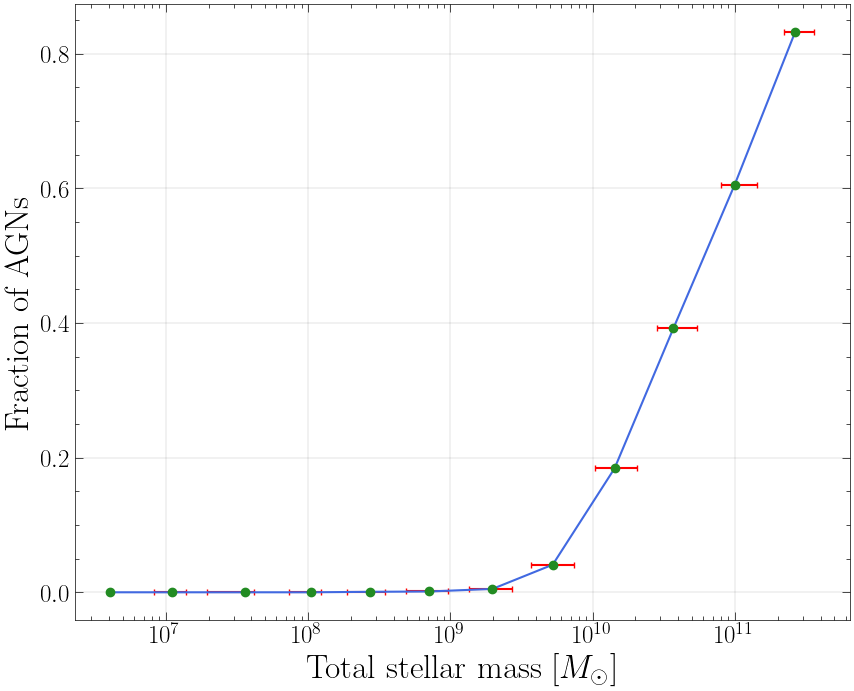

In [49]:
bins_info = Bin_analysis(results['best.stellar.m_star'][mask], agn_mask,
                         xbins=20) # x_min=6e-5
Bin_plotter(bins_info, x_key='quantiles', y_key='qty_frac',
            plt_err=True, err_type='quantiles',
            x_label='Total stellar mass $[M_\odot]$', y_label='Fraction of AGNs',
            markersize=12, linestyle='-',
            ecolor='red', color='royalblue', markerfacecolor='forestgreen', markeredgecolor='forestgreen',
            bad_bins=list(range(8)));

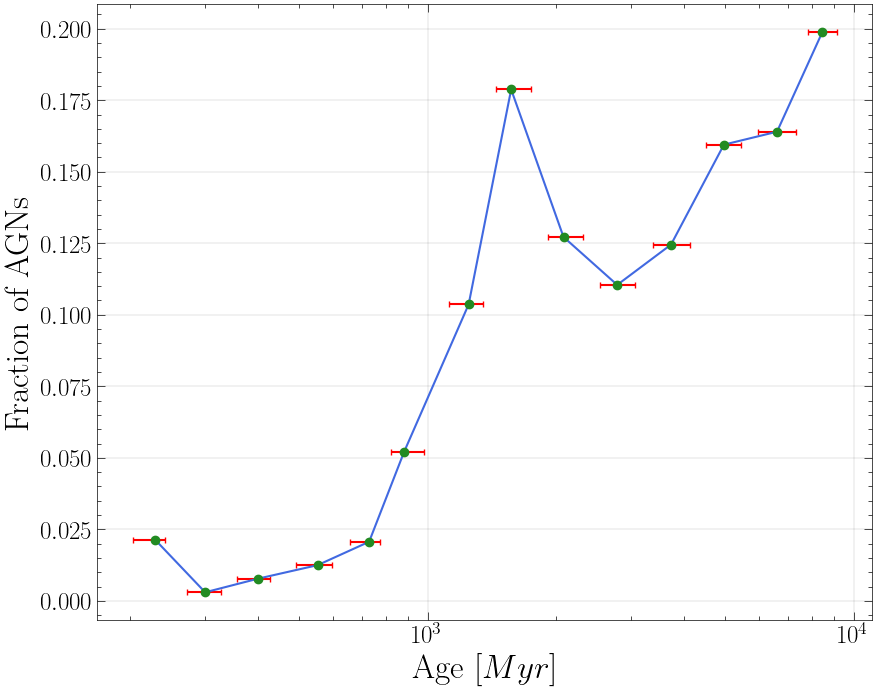

In [50]:
bins_info = Bin_analysis(results['best.stellar.age_m_star'][mask], agn_mask,
                         xbins=20)
Bin_plotter(bins_info, x_key='quantiles', y_key='qty_frac',
            plt_err=True, err_type='quantiles',
            x_label='Age $[Myr]$', y_label='Fraction of AGNs',
            markersize=12, linestyle='-',
            ecolor='red', color='royalblue', markerfacecolor='forestgreen', markeredgecolor='forestgreen',
            bad_bins=list(range(5)) + [len(bins_info) - 1]);

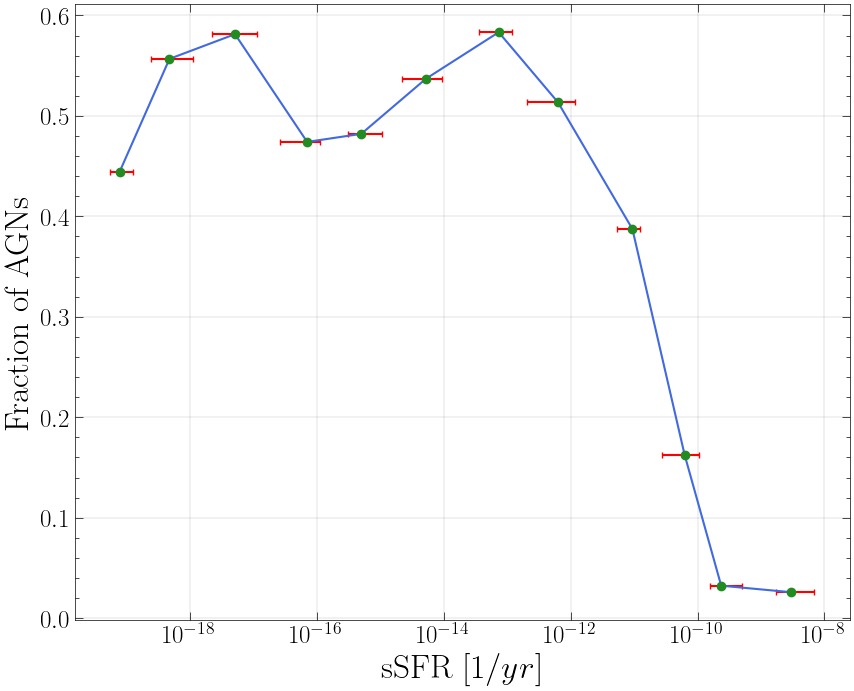

In [51]:
bins_info = Bin_analysis(results['best.sfh.sfr10Myrs'][mask] / results['best.stellar.m_star'][mask], agn_mask,
                         xbins=20) # x_min=3e-14
Bin_plotter(bins_info, x_key='quantiles', y_key='qty_frac',
            plt_err=True, err_type='quantiles',
            x_label='sSFR $[1/yr]$', y_label='Fraction of AGNs',
            markersize=12, linestyle='-',
            ecolor='red', color='royalblue', markerfacecolor='forestgreen', markeredgecolor='forestgreen',
            bad_bins=list(range(8)));

Search for relations between properties and agn

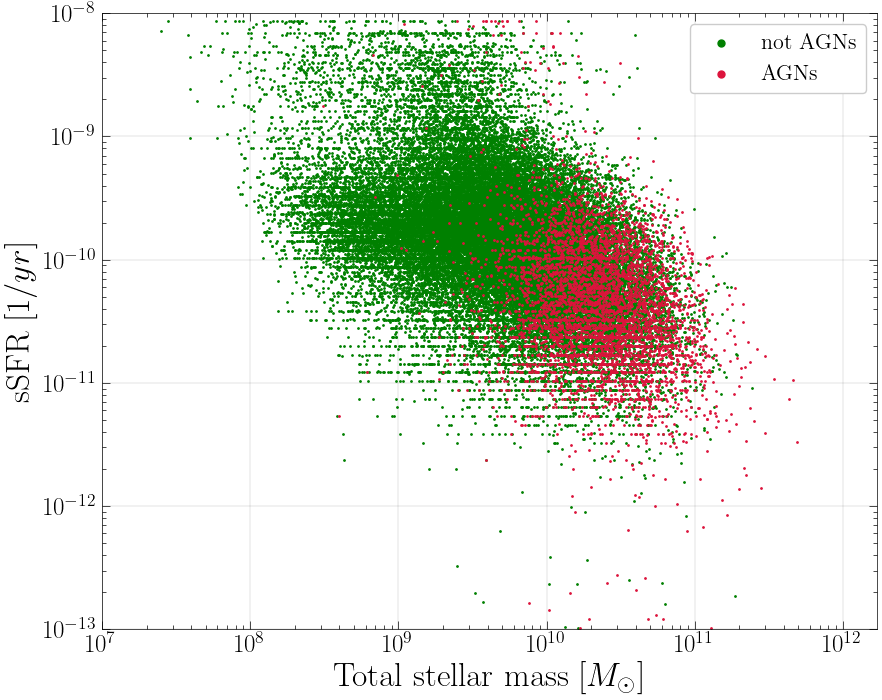

In [52]:
x_data = results['best.stellar.m_star'][mask]
y_data = results['best.sfh.sfr10Myrs'][mask]/results['best.stellar.m_star'][mask]

fig, ax = plt.subplots(1, 1)

ax.scatter(x_data[~agn_mask], y_data[~agn_mask], s=1, color='green', label='not AGNs')
ax.scatter(x_data[agn_mask], y_data[agn_mask], s=1, color='crimson', label='AGNs')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e7)
ax.set_ylim(1e-13, 1e-8)
ax.set_xlabel('Total stellar mass $[M_\odot]$')
ax.set_ylabel('sSFR $[1/yr]$')

ax.legend(markerscale=5);